In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn

import utils
import aug_functions
import bnn_aug

import warnings
warnings.filterwarnings("ignore")

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font',**{'family':'serif'})
rc('text', usetex=True)
rc('text.latex', preamble='''
        \\usepackage[utf8]{inputenc}
        \\usepackage{amssymb}
        \\usepackage{amsfonts}
        \\usepackage[russian]{babel}''')

In [4]:
data = pd.read_csv('../data/plasticc/good_objects.csv', index_col=0)

data = data[data.detected == 1]
data.head()

,object_id,mjd,passband,flux,flux_err,detected,log_lam,class
222,13,60532.3019,2,24.529644,1.046373,1,3.790512,0
223,13,60532.3097,1,23.404964,0.992504,1,3.675929,0
224,13,60532.3173,3,36.069386,1.568371,1,3.875155,0
225,13,60532.3282,4,42.765503,2.305008,1,3.938479,0
226,13,60532.3392,5,36.567162,5.439748,1,3.987288,0


In [5]:
object_ids = np.unique(data.object_id)

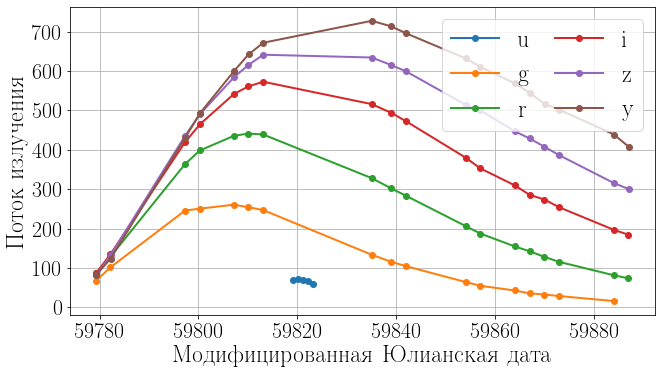

In [6]:
anobject = aug_functions.get_object(data, 34299)

aug_functions.plot_light_curves(anobject)

In [7]:
from sklearn.model_selection import train_test_split
anobject_train, anobject_test = train_test_split(anobject, test_size=0.36, random_state=11)

X_train = anobject_train[['mjd', 'log_lam']].values
X_test = anobject_test[['mjd', 'log_lam']].values

from sklearn.preprocessing import StandardScaler
ss_x = StandardScaler()
X_train_ss = ss_x.fit_transform(X_train)
X_test_ss = ss_x.transform(X_test)

ss_y = StandardScaler()
y_train_ss = ss_y.fit_transform(anobject_train['flux'].values.reshape((-1, 1)))

reg = bnn_aug.FitBNNRegressor(n_hidden=100, n_epochs=1000, lr=0.1, kl_weight=0.0001, optimizer='Adam')
reg.fit(X_train_ss, y_train_ss)

# predict flux for unseen observations
anobject_test_pred = anobject_test.copy()
res = reg.predict(X_test_ss)
anobject_test_pred['flux'] = ss_y.inverse_transform(res)

# predict flux for known observations
anobject_train_pred = anobject_train.copy()
res = reg.predict(X_train_ss)
anobject_train_pred['flux'] = ss_y.inverse_transform(res)

# calculate quality metrics
[rmse, mae, rse, rae, mape] = utils.regression_quality_metrics_report(anobject_test['flux'].values, 
                                                                      anobject_test_pred['flux'])
print("RMSE: ", rmse)
print("MAE: ", mae)
print("RSE: ", rse)
print("RAE: ", rae)
print("MAPE: ", mape)

RMSE:  37.666961329408245
MAE:  32.20671311476945
RSE:  0.17906091092563012
RAE:  0.17196878676422064
MAPE:  32.6266861632021


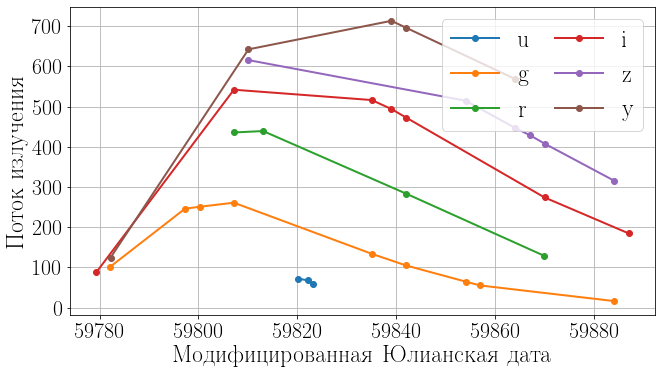

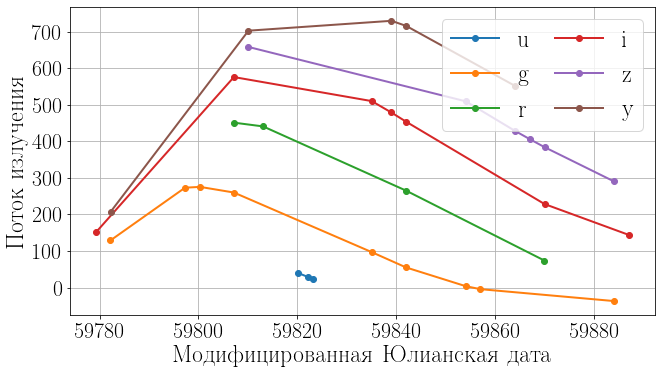

In [8]:
aug_functions.plot_light_curves(anobject_test, "Test observations")
aug_functions.plot_light_curves(anobject_test_pred, "Predictions on the test")

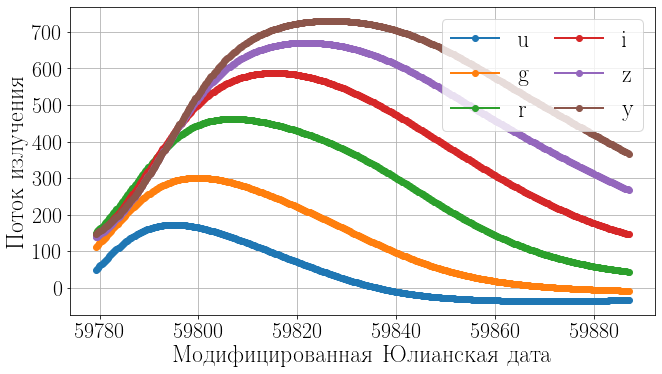

In [9]:
approx_object = aug_functions.create_approx_object(anobject)
X = approx_object[['mjd', 'log_lam']].values

X_ss = ss_x.transform(X)
res, std = reg.predict_n_times(X_ss, ss_y, 100)
approx_object['flux'] = res
approx_object['flux_err'] = std
aug_functions.plot_light_curves(approx_object, "Approximation")

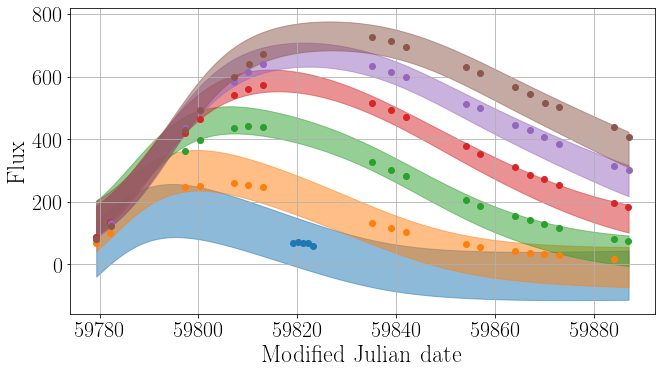

In [10]:
anobject_pic_real = anobject.sort_values('mjd')
anobject_pic_aug = approx_object.sort_values('mjd')
colors = ['C' + str(i) for i in range(6)]

fig = plt.figure(figsize=(9, 5), tight_layout = {'pad': 0})
for passband in range(6):
    light_curve_real = aug_functions.get_passband(anobject_pic_real, passband)
    light_curve_aug = aug_functions.get_passband(anobject_pic_aug, passband)
    plt.plot(light_curve_real['mjd'].values, light_curve_real['flux'].values, 'o', linewidth=2)
    plt.fill_between(light_curve_aug['mjd'].values,
                     light_curve_aug['flux'].values - 3 * light_curve_aug['flux_err'].values,
                     light_curve_aug['flux'].values + 3 * light_curve_aug['flux_err'].values,
                     label=aug_functions.passband2name[passband], alpha=0.5, color=colors[passband])
#plt.title('Ожидаемый разброс значений $\hat{f}(x) \pm 3 \sigma$', fontsize=28, pad=8.0)
plt.xlabel('Modified Julian date', fontsize=24)
plt.xticks(fontsize=22)
plt.ylabel('Flux', fontsize=24)
plt.yticks(fontsize=22)
#plt.legend(loc='upper right', ncol=2, fontsize=24, columnspacing=1.0)
plt.grid(True)
plt.show()
#fig.savefig("../pictures/light_curve_{}_{}.pdf".format(anobject.object_id.to_numpy()[0], 
#            augmentation_model), bbox_inches='tight', pad_inches=0.0)#

In [11]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred) / y_true) * 100

In [12]:
from tqdm import tqdm
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed

def test_one_object(i, n_hidden, n_epochs, lr, kl_weight, optimizer):
    good_id = object_ids[i]
    
    # get an object
    anobject = aug_functions.get_object(data, good_id)

    # train / test split
    anobject_train, anobject_test = train_test_split(anobject, test_size=0.36, random_state=11)

    y_train = anobject_train['flux'].values
    y_test  = anobject_test['flux'].values

    t       = anobject_train['mjd'].values.reshape((-1, 1))
    X_train = np.concatenate((t, anobject_train['log_lam'].values.reshape((-1, 1))), axis=1) 
        
    t       = anobject_test['mjd'].values.reshape((-1, 1))
    X_test  = np.concatenate((t, anobject_test['log_lam'].values.reshape((-1, 1))), axis=1)
        
    ss_x = StandardScaler()
    X_train_ss = ss_x.fit_transform(X_train)
    X_test_ss = ss_x.transform(X_test)

    ss_y = StandardScaler()
    y_train_ss = ss_y.fit_transform(y_train.reshape((-1, 1)))

    # fit a regression model to approximate light curves
    reg = bnn_aug.FitBNNRegressor(n_hidden=n_hidden, 
                                     n_epochs=n_epochs, 
                                     kl_weight=kl_weight,          
                                     lr=lr, 
                                     optimizer=optimizer)
    reg.fit(X_train_ss, y_train_ss)

    # predict flux for unseen observations
    anobject_test_pred = anobject_test.copy()
    y_pred = ss_y.inverse_transform(reg.predict(X_test_ss)).reshape(y_test.shape)

    metrics = utils.regression_quality_metrics_report(y_test, y_pred)
    return metrics

def gen_report(metrics):
    report = pd.DataFrame(columns=["ID", 'RMSE', 'MAE', 'RSE', 'RAE', 'MAPE'])
    for i, met in enumerate(metrics):
        if met is not None:
            report.loc[len(report), :] = [i] + list(met)
    return report

def test_model(part_ids, n_hidden, n_epochs, lr, kl_weight, optimizer):
    metrics = Parallel(n_jobs=-1)(delayed(test_one_object)(good_id, n_hidden, n_epochs, lr, kl_weight, optimizer) for good_id in part_ids)
    report  = gen_report(metrics)
    return report

  0%|          | 0/19 [00:00<?, ?it/s]

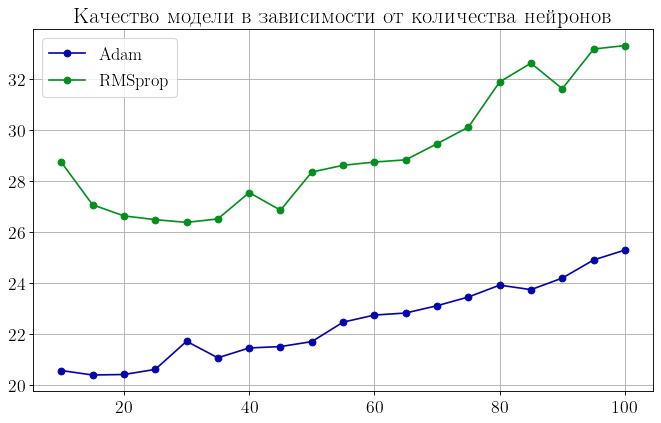

In [15]:
adam_metrics = []
RMSprop_metrics = []

neurons_number = np.arange(10, 101, 5)
index = np.random.choice(len(object_ids), size=len(object_ids) // 5)

for neurons in tqdm_notebook(neurons_number):
    adam_mape = test_model(index, n_hidden=neurons, n_epochs=1000, lr=0.07, kl_weight=0.0001, optimizer='Adam')
    adam_metrics.append(adam_mape.MAPE.mean())
    RMSprop_mape = test_model(index, n_hidden=neurons, n_epochs=1000, lr=0.01, kl_weight=0.01, optimizer='RMSprop')
    RMSprop_metrics.append(RMSprop_mape.MAPE.mean())

fig = plt.figure(dpi=80, figsize=(10, 6))
plt.title("Качество модели в зависимости от количества нейронов", fontsize=20)
plt.grid(True)
plt.plot(neurons_number, adam_metrics, "-o", color="xkcd:royal blue", label="Adam")
plt.plot(neurons_number, RMSprop_metrics, "-o", color="xkcd:emerald green", label="RMSprop")
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()
fig.savefig("../pictures/metrics_nhidden_bayesian.pdf")

  0%|          | 0/18 [00:00<?, ?it/s]

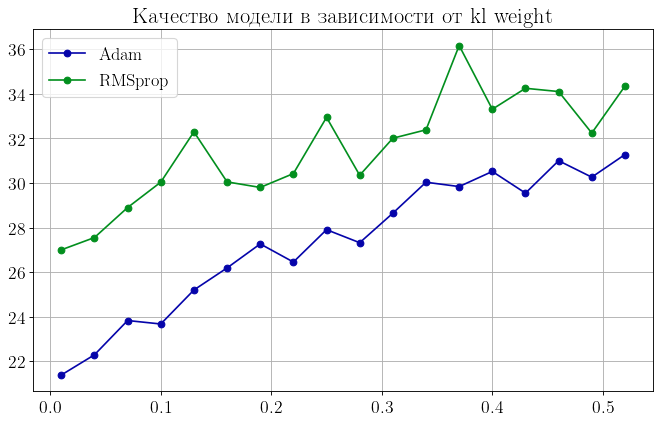

In [12]:
adam_metrics = []
RMSprop_metrics = []

kl_weight = np.concatenate((np.arange(0.0001, 0.1, 0.007), [0.1]))
index = np.random.choice(len(object_ids), size=len(object_ids) // 5)

for kl in tqdm_notebook(kl_weight):
    adam_mape = test_model(index, n_hidden=20, n_epochs=1000, lr=0.1, kl_weight=kl, optimizer='Adam')
    adam_metrics.append(adam_mape.MAPE.mean())
    RMSprop_mape = test_model(n_hidden=20, n_epochs=1000, lr=0.01, kl_weight=kl, optimizer='RMSprop')
    RMSprop_metrics.append(RMSprop_mape.MAPE.mean())
    
fig = plt.figure(dpi=80, figsize=(10, 6))
plt.title("Качество модели в зависимости от kl weight", fontsize=20)
plt.grid(True)
plt.plot(kl_weight, adam_metrics, "-o", color="xkcd:royal blue", label="Adam")
plt.plot(kl_weight, RMSprop_metrics, "-o", color="xkcd:emerald green", label="RMSprop")
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()
fig.savefig("../pictures/metrics_kl_bayesian.pdf")

  0%|          | 0/20 [00:00<?, ?it/s]

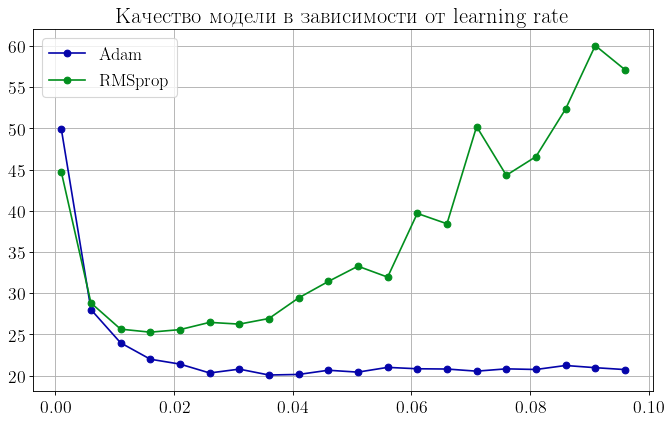

In [13]:
adam_metrics = []
RMSprop_metrics = []

learning_rate = np.arange(0.001, 0.1, 0.005)
index = np.random.choice(len(object_ids), size=len(object_ids) // 5)

for lr in tqdm_notebook(learning_rate):
    adam_mape = test_model(index, n_hidden=20, n_epochs=1000, lr=lr, kl_weight=0.0001, optimizer='Adam')
    adam_metrics.append(adam_mape.MAPE.mean())
    RMSprop_mape = test_model(index, n_hidden=30, n_epochs=1000, lr=lr, kl_weight=0.01, optimizer='RMSprop')
    RMSprop_metrics.append(RMSprop_mape.MAPE.mean())
    
fig = plt.figure(dpi=80, figsize=(10, 6))
plt.title("Качество модели в зависимости от learning rate", fontsize=20)
plt.grid(True)
plt.plot(learning_rate, adam_metrics, "-o", color="xkcd:royal blue", label="Adam")
plt.plot(learning_rate, RMSprop_metrics, "-o", color="xkcd:emerald green", label="RMSprop")
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()
fig.savefig("../pictures/metrics_lr_bayesian.pdf")

  0%|          | 0/9 [00:00<?, ?it/s]

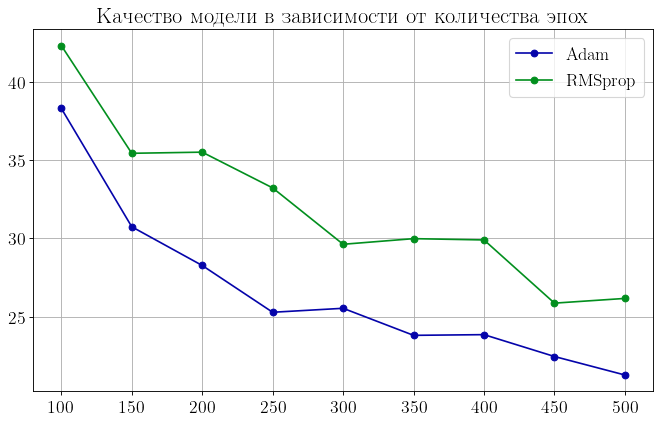

In [14]:
sgd_metrics = []
adam_metrics = []
RMSprop_metrics = []

epochs_range = np.arange(100, 501, 50)
index = np.random.choice(len(object_ids), size=len(object_ids) // 5)

for epochs in tqdm_notebook(epochs_range):
    adam_mape = test_model(index, n_hidden=20, n_epochs=epochs, lr=0.07, kl_weight=0.01, optimizer='Adam')
    adam_metrics.append(adam_mape.MAPE.mean())
    RMSprop_mape = test_model(index, n_hidden=25, n_epochs=epochs, lr=0.01, kl_weight=0.01, optimizer='RMSprop')
    RMSprop_metrics.append(RMSprop_mape.MAPE.mean())
    
fig = plt.figure(dpi=80, figsize=(10, 6))
plt.title("Качество модели в зависимости от количества эпох", fontsize=20)
plt.grid(True)
plt.plot(epochs_range, adam_metrics, "-o", color="xkcd:royal blue", label="Adam")
plt.plot(epochs_range, RMSprop_metrics, "-o", color="xkcd:emerald green", label="RMSprop")
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()
fig.savefig("../pictures/metrics_nepochs_bayesian.pdf")

### Посмотрим разброс предсказанных значений

In [15]:
def plot_light_curves_with_sigma(anobject, anobject_real, title=""):
    anobject = anobject.sort_values('mjd')
    colors = ['C'+str(i) for i in range(6)]
    plt.figure(figsize=(9, 4))
    for passband in range(6):
        light_curve = get_passband(anobject, passband)
        light_curve_real = get_passband(anobject_real, passband)
        plt.plot(light_curve['mjd'].values, light_curve['flux'].values, linewidth=2., color=colors[passband])
        plt.fill_between(light_curve['mjd'].values, 
                         light_curve['flux'].values+3*light_curve['flux_err'].values, 
                         light_curve['flux'].values-3*light_curve['flux_err'].values, label=passband2name[passband], alpha=0.5, color=colors[passband])
        plt.scatter(light_curve_real['mjd'].values, light_curve_real['flux'].values, linewidth=1, color=colors[passband])
    plt.xlabel('Modified Julian Date', size=14)
    plt.xticks(size=14)
    plt.ylabel('Flux', size=14)
    plt.yticks(size=14)
    plt.legend(loc='best', ncol=3, fontsize=14)
    plt.title(title, size=14)

In [16]:
approx_object = create_approx_object(anobject)
X = approx_object[['mjd', 'log_lam']].values
X_ss = ss.transform(X)

approx_flux, approx_flux_err = reg.predict_n_times(X_ss, n_times=1000)
approx_object['flux'], approx_object['flux_err'] = ss_y.inverse_transform(approx_flux), approx_flux_err

plot_light_curves_with_sigma(approx_object, anobject_test, "Approximation: " + r"$\mu \pm 3\sigma$")
plt.savefig('approx_light_curve_34299.pdf', format='pdf')

NameError: name 'create_approx_object' is not defined

# Test on many objects

In [21]:
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed

def one_object_run(i):
    
    # get an object
    anobject = aug_functions.get_object(data, i)
    
    # train / test split
    anobject_train, anobject_test = train_test_split(anobject, test_size=0.36, random_state=11)
    
    y_train = anobject_train['flux'].values
    y_test  = anobject_test['flux'].values

    t       = anobject_train['mjd'].values.reshape((-1, 1))
    X_train = np.concatenate((t, anobject_train['log_lam'].values.reshape((-1, 1))), axis=1) 
        
    t       = anobject_test['mjd'].values.reshape((-1, 1))
    X_test  = np.concatenate((t, anobject_test['log_lam'].values.reshape((-1, 1))), axis=1)
        
    ss_x = StandardScaler()
    X_train_ss = ss_x.fit_transform(X_train)
    X_test_ss = ss_x.transform(X_test)

    ss_y = StandardScaler()
    y_train_ss = ss_y.fit_transform(y_train.reshape((-1, 1)))

    reg_bnn = bnn_aug.FitBNNRegressor(n_hidden=80, n_epochs=1000, lr=0.1, kl_weight=0.01, optimizer='Adam', debug=0)
    reg_bnn.fit(X_train_ss, y_train_ss)

    
    # predict flux for unseen observations
    anobject_test_pred = anobject_test.copy()
    anobject_test_pred['flux'] = ss_y.inverse_transform(reg_bnn.predict(X_test_ss)).reshape(y_test.shape)
    
    metrics = utils.regression_quality_metrics_report(anobject_test['flux'].values, 
                                                      anobject_test_pred['flux'].values)
    
    return metrics

In [22]:
def gen_report(metrics):
    report = pd.DataFrame(columns=["ID", 'RMSE', 'MAE', 'RSE', 'RAE', 'MAPE'])
    for i, met in enumerate(metrics):
        if met is not None:
            report.loc[len(report), :] = [i] + list(met)
    return report

In [23]:
%%time

metrics = Parallel(n_jobs=-1)(delayed(one_object_run)(i) for i in object_ids)
report  = gen_report(metrics)
np.round(report.mean(), 2)

CPU times: user 23.9 s, sys: 712 ms, total: 24.6 s
Wall time: 32min 23s


ID      1253.50
RMSE      19.56
MAE       12.54
RSE        0.31
RAE        0.27
MAPE      19.78
dtype: float64

In [29]:
%%time

augmentation_model = "GP"
metrics   = Parallel(n_jobs=-1)(delayed(one_object_run)(i) for i in object_ids)
report_gp = gen_report(metrics)

CPU times: user 41.7 s, sys: 2.15 s, total: 43.8 s
Wall time: 44.4 s


In [30]:
%%time

augmentation_model = "BNN"
metrics   = Parallel(n_jobs=-1)(delayed(one_object_run)(i) for i in object_ids)
report_bnn = gen_report(metrics)

CPU times: user 27.8 s, sys: 1.11 s, total: 28.9 s
Wall time: 1min 11s


In [31]:
print("Metrics for GP:")
np.round(report_gp.mean(), 2)

Metrics for GP:


ID      1084.47
RMSE      24.65
MAE       12.28
RSE        0.16
RAE        0.14
MAPE      16.55
dtype: float64

In [32]:
print("Metrics for BNN:")
np.round(report_bnn.mean(), 2)

Metrics for BNN:


ID      1084.47
RMSE      26.21
MAE       15.87
RSE        0.18
RAE        0.15
MAPE      15.84
dtype: float64

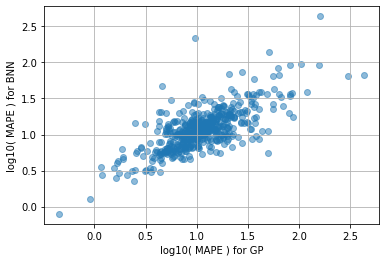

In [33]:
plt.scatter(np.log10(report_gp['MAPE'].values.astype(np.float)), 
            np.log10(report_bnn['MAPE'].values.astype(np.float)), alpha=0.5)
plt.xlabel("log10( MAPE ) for GP")
plt.ylabel("log10( MAPE ) for BNN")
plt.grid(b=1)
plt.show()

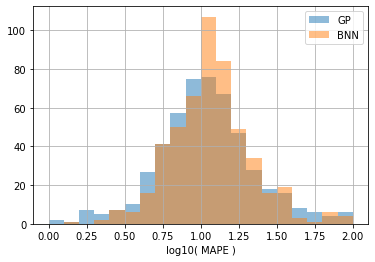

In [34]:
bins = np.linspace(0, 2, 21)
plt.figure(figsize=(6, 8))
plt.hist(np.log10(report_gp['MAPE'].values.astype(np.float)), bins=bins, alpha=0.5, label='GP')
plt.hist(np.log10(report['MAPE'].values.astype(np.float)), bins=bins, alpha=0.5, label='BNN')
plt.xlabel("log10(MAPE)", fontsize=16)
plt.grid(b=1)
plt.legend()
plt.show()